In [0]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statistics as stats
import random as rn
import os
import tensorflow.compat.v1 as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.activations import relu
from keras import initializers as init
from keras.constraints import max_norm
from tensorflow.compat.v1.keras import backend as K
from math import sqrt

from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


In [0]:
# ensure repeatability
K.clear_session()
tf.reset_default_graph()

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(23)
rn.seed(23)
tf.random.set_random_seed(23)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Parameters
test_size=0.127
val_size=0.2

epochs=50000
batch_size=55
learning_rate=5e-4
adam_decay=5e-4
dropout=0.4
noise=0.001
k_reg= 0.0055
activation='relu'

In [0]:
# load data
data = pd.read_csv("ML_data.csv", sep="|")
outliers = pd.read_csv("KNN_outliers.csv", sep="|", index_col=0)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

###### DATA PRE-PROCESSING ######

# drop outliers found by KNN from original ML dataset
for index in outliers.index:
    data.drop(index=index, inplace=True)

# add in various functions to x
x = data.iloc[:, 10:52]
y = data.iloc[:, 6:10]
labels = data.iloc[:, 0:3]

# separate categorical and continuous data 
categorical=pd.DataFrame()
continuous=pd.DataFrame()

for index in x.columns:
    if(x[index].dtypes == "int"):
        categorical[index]=x[index]
    elif(x[index].dtypes == "float"):
        continuous[index]=x[index]
    else:
        pass

# one hot encode categorical data
onehotencoder = OneHotEncoder()
categorical = onehotencoder.fit_transform(categorical).toarray()

# standardize continuous data
scaler = StandardScaler()
continuous = scaler.fit_transform(continuous)

# re-combine categorical and continuous data
x = np.concatenate((continuous, categorical), axis=1)
x = pd.DataFrame(x)

# extract y data and standardize (DFT predicted / output)
y = scaler.fit_transform(y)
y = pd.DataFrame(y)

# re-add labels
labels.reset_index(drop=True, inplace=True)
x = pd.concat([labels, x], axis=1)
y = pd.concat([labels, y], axis=1)

# equally split train/val/test data based on overall distribution of semiconductor
# tpye and defect site
x_training, x_test, y_training, y_test = train_test_split(x, y,
                                                          test_size=test_size,
                                                          stratify=y[['Type', 'Site']],
                                                          random_state=23)
x_train, x_val, y_train, y_val = train_test_split(x_training, y_training, 
                                                  test_size=val_size,
                                                  stratify=y_training[['Type', 'Site']],
                                                  random_state=23)

# seperate test and validation sets by type 
x_test.sort_values(by=["Type"], inplace=True)
y_test.sort_values(by=["Type"], inplace=True)

y_test_two_six = y_test.iloc[0:59]
y_test_three_five = y_test.iloc[59:77]
y_test_four_four = y_test.iloc[77:100]
x_test_two_six = x_test.iloc[0:59]
x_test_three_five = x_test.iloc[59:77]
x_test_four_four = x_test.iloc[77:100]

# seperate test and validation sets by type 
x_test.sort_values(by=["Site"], inplace=True)
y_test.sort_values(by=["Site"], inplace=True)

y_test_MA = y_test.iloc[0:21]
y_test_MB = y_test.iloc[21:38]
y_test_MiA = y_test.iloc[38:60]
y_test_MiB = y_test.iloc[60:79]
y_test_MiNeut = y_test.iloc[79:100]
x_test_MA = x_test.iloc[0:21]
x_test_MB = x_test.iloc[21:38]
x_test_MiA = x_test.iloc[38:60]
x_test_MiB = x_test.iloc[60:79]
x_test_MiNeut = x_test.iloc[79:100]

# remove labels out of dataframes
for dataset in [x_train, x_val, x_test, y_train, y_val, y_test,
                y_test_two_six, y_test_three_five, y_test_four_four,
                x_test_two_six, x_test_three_five, x_test_four_four,
                y_test_MA, y_test_MB, y_test_MiA, y_test_MiB, y_test_MiNeut,
                x_test_MA, x_test_MB, x_test_MiA, x_test_MiB, x_test_MiNeut]:
    dataset.drop(columns=dataset.columns[0:3], inplace=True)

x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

y_test_two_six = y_test_two_six.to_numpy()
y_test_three_five = y_test_three_five.to_numpy()
y_test_four_four = y_test_four_four.to_numpy()
x_test_two_six = x_test_two_six.to_numpy()
x_test_three_five = x_test_three_five.to_numpy()
x_test_four_four = x_test_four_four.to_numpy()

y_test_MA = y_test_MA.to_numpy()
y_test_MB = y_test_MB.to_numpy()
y_test_MiA = y_test_MiA.to_numpy()
y_test_MiB = y_test_MiB.to_numpy()
y_test_MiNeut = y_test_MiNeut.to_numpy()
x_test_MA = x_test_MA.to_numpy()
x_test_MB = x_test_MB.to_numpy()
x_test_MiA = x_test_MiA.to_numpy()
x_test_MiB = x_test_MiB.to_numpy()
x_test_MiNeut = x_test_MiNeut.to_numpy()

# input and output dimension
in_dim = x_train.shape[1]
out_dim = y_train.shape[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to b

In [0]:
print("Training Samples: %.f" % x_train.shape[0])
print("Valdtion Samples: %.f" % x_val.shape[0])
print("Testing Samples: %.f" % x_test.shape[0])
in_dim

Training Samples: 547
Valdtion Samples: 137
Testing Samples: 100


219

In [0]:
# construct model

def neural_network():
    
    # Create and add layers to model
    model = Sequential()
    #### Input layer
    model.add(Dense(220,
                    input_dim=in_dim, 
                    activation='relu',
                    kernel_regularizer=l1_l2(k_reg),
                    kernel_constraint=max_norm(1), 
                    bias_constraint=max_norm(1)
                    )
             )
    model.add(Dropout(dropout))
    model.add(GaussianNoise(noise))

    ## hidden layers
    model.add(Dense(110, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(110, activation='relu'))
    model.add(Dropout(dropout))

    ## output layers
    model.add(Dense(out_dim)) #, activation='linear'))

    # configure optimizer & compile model
    opt = Adam(lr=learning_rate, decay=adam_decay)
    model.compile(loss="mse", optimizer=opt)

    # summarize model
    print(model.summary())

    # train model
    prediction = model.fit(x_train, y_train,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1)
    
    return (model, prediction)

In [0]:
model, prediction = neural_network()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 220)               48400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 220)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 220)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 110)               24310     
_________________________________________________________________
dropout_2 (Dropout)          (None, 110)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 110)               12210     
_________________________________________________________________
dropout_3 (Dropout)          (None, 110)              

In [0]:
pred_train = model.predict(x_train)
pred_val = model.predict(x_val)
pred_test = model.predict(x_test)

print("- - - - - - - - - - - - - - - - - - - -")
print("RMSE Training / Val. / Testing (eV):")
print("(+2/+1): %.4f / %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,0], pred_train[:,0])),
                                       (sqrt(mean_squared_error(y_val[:,0], pred_val[:,0]))),
                                       (sqrt(mean_squared_error(y_test[:,0], pred_test[:,0])))
                                       ))
print("(+1/0): %.4f / %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,1], pred_train[:,1])),
                                       (sqrt(mean_squared_error(y_val[:,1], pred_val[:,1]))),
                                       (sqrt(mean_squared_error(y_test[:,1], pred_test[:,1])))
                                       ))
print("(0/-1): %.4f / %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,2], pred_train[:,2])),
                                       (sqrt(mean_squared_error(y_val[:,2], pred_val[:,2]))),
                                       (sqrt(mean_squared_error(y_test[:,2], pred_test[:,2])))
                                       ))
print("(-1/-2): %.4f / %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,2], pred_train[:,3])),
                                       (sqrt(mean_squared_error(y_val[:,2], pred_val[:,3]))),
                                       (sqrt(mean_squared_error(y_test[:,2], pred_test[:,3])))
                                       ))
print("- - - - - - - - - - - - - - - - - - - -")
RMSE_train = (stats.mean([sqrt(mean_squared_error(y_train[:,0], pred_train[:,0])), 
                        sqrt(mean_squared_error(y_train[:,1], pred_train[:,1])),  
                        sqrt(mean_squared_error(y_train[:,2], pred_train[:,2])),
                        sqrt(mean_squared_error(y_train[:,3], pred_train[:,3]))
                        ])
            )
RMSE_val = (stats.mean([sqrt(mean_squared_error(y_val[:,0], pred_val[:,0])), 
                        sqrt(mean_squared_error(y_val[:,1], pred_val[:,1])),  
                        sqrt(mean_squared_error(y_val[:,2], pred_val[:,2])),
                        sqrt(mean_squared_error(y_val[:,3], pred_val[:,3]))
                        ])
            )
RMSE_test = (stats.mean([sqrt(mean_squared_error(y_test[:,0], pred_test[:,0])), 
                        sqrt(mean_squared_error(y_test[:,1], pred_test[:,1])),  
                        sqrt(mean_squared_error(y_test[:,2], pred_test[:,2])),
                        sqrt(mean_squared_error(y_test[:,3], pred_test[:,3]))
                        ])
            )
print("Mean TRAIN RMSE: %.4f eV" % (RMSE_train))
print("Mean VAL RMSE: %.4f eV" % (RMSE_val))
print("Mean TEST RMSE: %.4f eV" % (RMSE_test))

print("- - - - - - - - - - - - - - - - - - - -")
low_epoch = (np.argmin(prediction.history["val_loss"]) + 1)
low_val_loss = np.amin(prediction.history["val_loss"])
low_epoch_train = (np.argmin(prediction.history["loss"]) + 1)
low_val_loss_train = np.amin(prediction.history["loss"])
print("Lowest Val. loss: %.4f at %s epochs" % (low_val_loss, low_epoch))
print("Lowest train loss: %.4f at %s epochs" % (low_val_loss_train, low_epoch_train))

- - - - - - - - - - - - - - - - - - - -
RMSE Training / Val. / Testing (eV):
(+2/+1): 0.2357 / 0.3785 / 0.4009
(+1/0): 0.2664 / 0.3453 / 0.3425
(0/-1): 0.2161 / 0.2657 / 0.3063
(-1/-2): 0.2496 / 0.2826 / 0.3191
- - - - - - - - - - - - - - - - - - - -
Mean TRAIN RMSE: 0.2232 eV
Mean VAL RMSE: 0.3034 eV
Mean TEST RMSE: 0.3303 eV
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.1115 at 47821 epochs
Lowest train loss: 0.1142 at 46904 epochs


Text(0.5, 1.0, 'Training/Validation Loss')

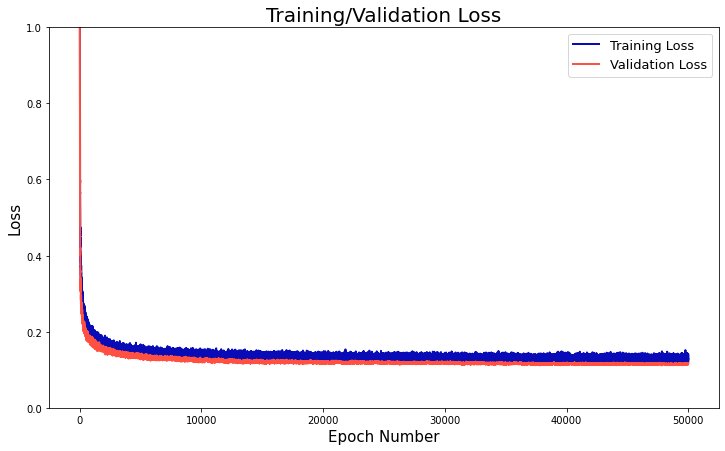

In [0]:
test_color = "#ff5042" 
val_color = "#080bb6"
train_color = "#bababa"

fig, ax = plt.subplots(figsize=(12, 7))
x_plot = np.arange(0, epochs)
ax.plot(x_plot, prediction.history["loss"], label="Training Loss", color=val_color, lw=2)
ax.plot(x_plot, prediction.history["val_loss"], label="Validation Loss", color=test_color, lw=2)
ax.legend(loc="upper right", fontsize=13)
ax.set_xlabel("Epoch Number", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.set_ylim(0, 1)
ax.set_title('Training/Validation Loss', fontsize=20)

(-3.005845855945267, 3.338126474878157)

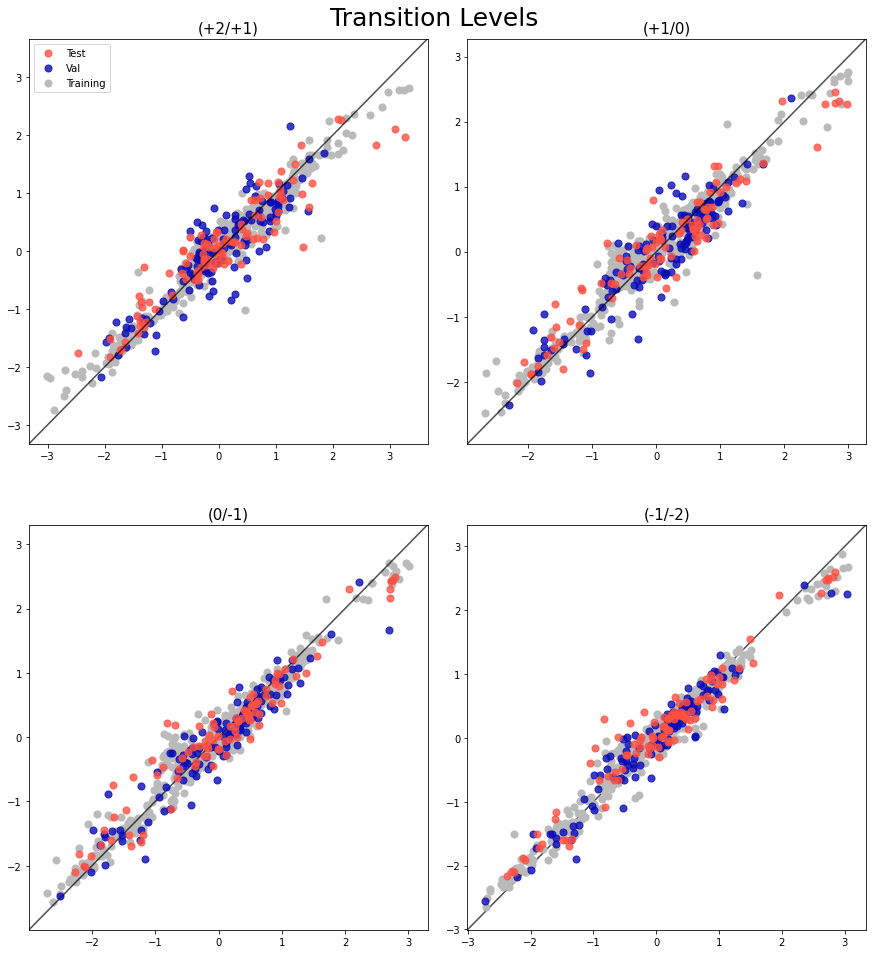

In [0]:
# plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=.2, wspace = 0.1, top=.95)
fig.suptitle("Transition Levels", fontsize=25, va='top')

subtitle_size=15
test_alpha = .8
val_alpha = .8
train_alpha = 1
scatter_size = 50

#############################################################
ax[0,0].set_title("(+2/+1)", fontsize=subtitle_size)
ax[0,0].scatter(y_test[:,0], pred_test[:,0], label="Test", color=test_color, alpha=test_alpha, zorder=3, s=scatter_size)
ax[0,0].scatter(y_val[:,0], pred_val[:,0], label="Val", color=val_color, alpha=val_alpha, zorder=2, s=scatter_size)
ax[0,0].scatter(y_train[:,0], pred_train[:,0], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[0,0].get_xlim(), ax[0,0].get_ylim()]),
        np.max([ax[0,0].get_xlim(), ax[0,0].get_ylim()])]
ax[0,0].plot(lims, lims, color="black", zorder=3, alpha=0.7)
ax[0,0].set_xlim(lims)
ax[0,0].set_ylim(lims)
ax[0,0].legend()

#############################################################
ax[0,1].set_title("(+1/0)", fontsize=subtitle_size)
ax[0,1].scatter(y_test[:,1], pred_test[:,1], label="Test", color=test_color, alpha=test_alpha, zorder=3, s=scatter_size)
ax[0,1].scatter(y_val[:,1], pred_val[:,1], label="Val", color=val_color, alpha=val_alpha, zorder=2, s=scatter_size)
ax[0,1].scatter(y_train[:,1], pred_train[:,1], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[0,1].get_xlim(), ax[0,1].get_ylim()]),
        np.max([ax[0,1].get_xlim(), ax[0,1].get_ylim()])]
ax[0,1].plot(lims, lims, color="black", zorder=3, alpha=0.7)
ax[0,1].set_xlim(lims)
ax[0,1].set_ylim(lims)

#############################################################
ax[1,0].set_title("(0/-1)", fontsize=subtitle_size)
ax[1,0].scatter(y_test[:,2], pred_test[:,2], label="Test", color=test_color, alpha=test_alpha, zorder=3, s=scatter_size)
ax[1,0].scatter(y_val[:,2], pred_val[:,2], label="Val", color=val_color, alpha=val_alpha, zorder=2, s=scatter_size)
ax[1,0].scatter(y_train[:,2], pred_train[:,2], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
        np.max([ax[1,0].get_xlim(), ax[1,0].get_ylim()])]
ax[1,0].plot(lims, lims, color="black", zorder=1, alpha=0.7)
ax[1,0].set_xlim(lims)
ax[1,0].set_ylim(lims)

#############################################################
ax[1,1].set_title("(-1/-2)", fontsize=subtitle_size)
ax[1,1].scatter(y_test[:,3], pred_test[:,3], label="Test", color=test_color, alpha=test_alpha, zorder=3, s=scatter_size)
ax[1,1].scatter(y_val[:,3], pred_val[:,3], label="Val", color=val_color, alpha=val_alpha, zorder=2, s=scatter_size)
ax[1,1].scatter(y_train[:,3], pred_train[:,3], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
        np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()])]
ax[1,1].plot(lims, lims, color="black", zorder=0, alpha=0.7)
ax[1,1].set_xlim(lims)
ax[1,1].set_ylim(lims)

Mean RMSE by Semiconductor Type:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
II-VI: 0.3053 eV (59 data points)
III-V: 0.3858 eV (18 data points)
IV-IV: 0.3402 eV (23 data points)

Mean RMSE by Defect Site:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
 MA: 0.3619 eV (21 data points)
 MB: 0.4008 eV (17 data points)
MiA: 0.2967 eV (22 data points)
MiB: 0.2879 eV (19 data points)
MiN: 0.2931 eV (21 data points)


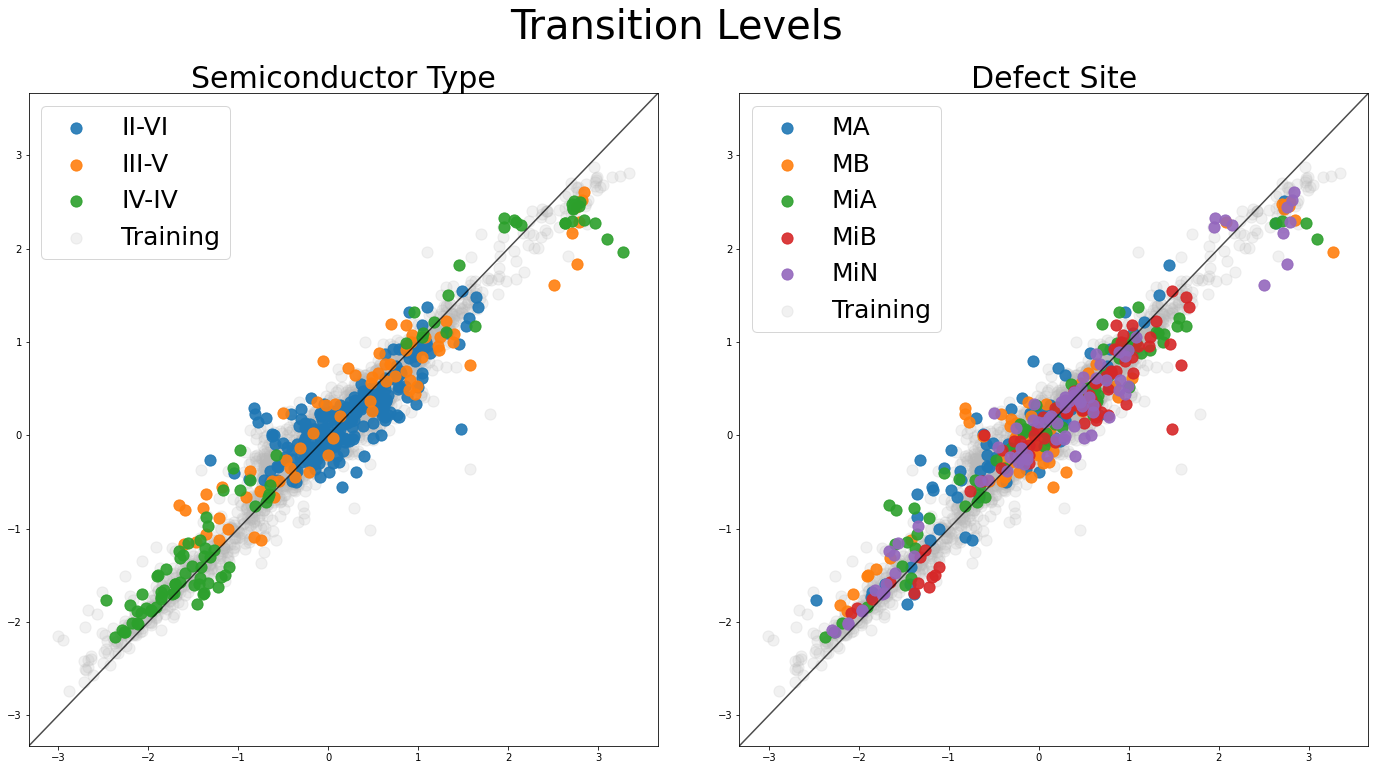

In [0]:
# Predictions based on Semiconductor Type and 
pred_two_six = model.predict(x_test_two_six)
pred_three_five = model.predict(x_test_three_five)
pred_four_four = model.predict(x_test_four_four)
pred_MA = model.predict(x_test_MA)
pred_MB = model.predict(x_test_MB)
pred_MiA = model.predict(x_test_MiA)
pred_MiB = model.predict(x_test_MiB)
pred_MiNeut = model.predict(x_test_MiNeut)

RMSE_two_six = (stats.mean([sqrt(mean_squared_error(y_test_two_six[:,0], pred_two_six[:,0])),
                            sqrt(mean_squared_error(y_test_two_six[:,1], pred_two_six[:,1])),
                            sqrt(mean_squared_error(y_test_two_six[:,2], pred_two_six[:,2])),
                            sqrt(mean_squared_error(y_test_two_six[:,3], pred_two_six[:,3]))
                           ])
            )
RMSE_three_five = (stats.mean([sqrt(mean_squared_error(y_test_three_five[:,0], pred_three_five[:,0])),
                               sqrt(mean_squared_error(y_test_three_five[:,1], pred_three_five[:,1])),
                               sqrt(mean_squared_error(y_test_three_five[:,2], pred_three_five[:,2])),
                               sqrt(mean_squared_error(y_test_three_five[:,3], pred_three_five[:,3]))
                              ])
            )
RMSE_four_four = (stats.mean([sqrt(mean_squared_error(y_test_four_four[:,0], pred_four_four[:,0])),
                              sqrt(mean_squared_error(y_test_four_four[:,1], pred_four_four[:,1])),
                              sqrt(mean_squared_error(y_test_four_four[:,2], pred_four_four[:,2])),
                              sqrt(mean_squared_error(y_test_four_four[:,3], pred_four_four[:,3]))
                             ])
            )
RMSE_MA = (stats.mean([sqrt(mean_squared_error(y_test_MA[:,0], pred_MA[:,0])),
                       sqrt(mean_squared_error(y_test_MA[:,1], pred_MA[:,1])),
                       sqrt(mean_squared_error(y_test_MA[:,2], pred_MA[:,2])),
                       sqrt(mean_squared_error(y_test_MA[:,3], pred_MA[:,3]))
                      ])
            )
RMSE_MB = (stats.mean([sqrt(mean_squared_error(y_test_MB[:,0], pred_MB[:,0])),
                       sqrt(mean_squared_error(y_test_MB[:,1], pred_MB[:,1])),
                       sqrt(mean_squared_error(y_test_MB[:,2], pred_MB[:,2])),
                       sqrt(mean_squared_error(y_test_MB[:,3], pred_MB[:,3]))
                      ])
            )
RMSE_MiA = (stats.mean([sqrt(mean_squared_error(y_test_MiA[:,0], pred_MiA[:,0])),
                        sqrt(mean_squared_error(y_test_MiA[:,1], pred_MiA[:,1])),
                        sqrt(mean_squared_error(y_test_MiA[:,2], pred_MiA[:,2])),
                        sqrt(mean_squared_error(y_test_MiA[:,3], pred_MiA[:,3]))
                       ])
            )
RMSE_MiB = (stats.mean([sqrt(mean_squared_error(y_test_MiB[:,0], pred_MiB[:,0])),
                        sqrt(mean_squared_error(y_test_MiB[:,1], pred_MiB[:,1])),
                        sqrt(mean_squared_error(y_test_MiB[:,2], pred_MiB[:,2])),
                        sqrt(mean_squared_error(y_test_MiB[:,3], pred_MiB[:,3]))
                       ])
            )
RMSE_MiNeut = (stats.mean([sqrt(mean_squared_error(y_test_MiNeut[:,0], pred_MiNeut[:,0])),
                           sqrt(mean_squared_error(y_test_MiNeut[:,1], pred_MiNeut[:,1])),
                           sqrt(mean_squared_error(y_test_MiNeut[:,2], pred_MiNeut[:,2])),
                           sqrt(mean_squared_error(y_test_MiNeut[:,3], pred_MiNeut[:,3]))
                          ])
            )
print("Mean RMSE by Semiconductor Type:")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
print("II-VI: %.4f eV (%s data points)" % (RMSE_two_six, x_test_two_six.shape[0]))
print("III-V: %.4f eV (%s data points)" % (RMSE_three_five, x_test_three_five.shape[0]))
print("IV-IV: %.4f eV (%s data points)" % (RMSE_four_four, x_test_four_four.shape[0]))
print("")
print("Mean RMSE by Defect Site:")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
print(" MA: %.4f eV (%s data points)" % (RMSE_MA, x_test_MA.shape[0]))
print(" MB: %.4f eV (%s data points)" % (RMSE_MB, x_test_MB.shape[0]))
print("MiA: %.4f eV (%s data points)" % (RMSE_MiA, x_test_MiA.shape[0]))
print("MiB: %.4f eV (%s data points)" % (RMSE_MiB, x_test_MiB.shape[0]))
print("MiN: %.4f eV (%s data points)" % (RMSE_MiNeut, x_test_MiNeut.shape[0]))

# plot results
fig2, axes = plt.subplots(1, 2, figsize=(24, 12))
fig2.subplots_adjust(wspace = 0.13, top=.88)
fig2.suptitle("Transition Levels", fontsize=40, va='top')

subtitle_size=30
scatter_alpha = 0.9
scatter_size = 125

#############################################################
axes[0].set_title("Semiconductor Type", fontsize=subtitle_size)
axes[0].scatter(y_test_two_six, pred_two_six, label="II-VI",
                alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[0].scatter(y_test_three_five, pred_three_five, label="III-V",
                alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[0].scatter(y_test_four_four, pred_four_four, label="IV-IV", 
                alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[0].scatter(y_train, pred_train, label="Training", color=train_color, 
                alpha=0.2, zorder=0, s=scatter_size)
lim = [np.min([axes[0].get_xlim(), axes[0].get_ylim()]),
        np.max([axes[0].get_xlim(), axes[0].get_ylim()])]
axes[0].plot(lim, lim, color="black", zorder=3, alpha=0.7)
axes[0].set_xlim(lim)
axes[0].set_ylim(lim)
axes[0].legend(fontsize=25)

#############################################################
axes[1].set_title("Defect Site", fontsize=subtitle_size)
axes[1].scatter(y_test_MA, pred_MA, label="MA", alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[1].scatter(y_test_MB, pred_MB, label="MB", alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[1].scatter(y_test_MiA, pred_MiA, label="MiA", alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[1].scatter(y_test_MiB, pred_MiB, label="MiB", alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[1].scatter(y_test_MiNeut, pred_MiNeut, label="MiN", alpha=scatter_alpha, zorder=2, s=scatter_size)
axes[1].scatter(y_train, pred_train, label="Training", color=train_color, 
                alpha=0.2, zorder=0, s=scatter_size)
lim = [np.min([axes[1].get_xlim(), axes[1].get_ylim()]),
        np.max([axes[1].get_xlim(), axes[1].get_ylim()])]
axes[1].plot(lim, lim, color="black", zorder=3, alpha=0.7)
axes[1].set_xlim(lim)
axes[1].set_ylim(lim)
axes[1].legend(fontsize=25)